** Script overview **

This script preprocesses the raw flight schedule data from OAG:
- It adds the great circle distance and the airport country.
- It filters routes with invalid great circle distances.
- It merges duplicate aircraft and airports (with slightly different names).
Finally it uploads everything.

## Load packages

In [16]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [17]:
def preview(dataframe, head=5):
    display(dataframe.head(head))
    print("This dataframe has " + str(len(dataframe)) + " observations.")

## Load and pre-process data

In [1]:
# Connect to DB
%load_ext ipython_pg.LAV
%pg_connect dbname='mobility' user='heldm'

password for heldm@lav-fileserver.ethz.ch:5433:········
SUCCESS: connected to lav-fileserver.ethz.ch
  PostGIS integration enabled

In [2]:
%%pg_pd oag18_raw
SELECT * FROM "OAG"."2018_schedule_raw"

SUCCES: matched 183211 rows
 results stored as 'oag18_raw'


In [3]:
oag18_raw.head()

,ac_code_iata,ac_name_oag,arr_ap_code,arr_ap_name,dep_ap_code,dep_ap_name,frequency_2018
0,100,Fokker 100,ADE,Aden,JIB,Djibouti,58.0
1,100,Fokker 100,AMS,Amsterdam,BRU,Brussels Airport,88.0
2,100,Fokker 100,AMS,Amsterdam,MUC,Munich International Airport,332.0
3,100,Fokker 100,AZD,Yazd,BND,Bandar Abbas,91.0
4,100,Fokker 100,BND,Bandar Abbas,AZD,Yazd,91.0


In [4]:
oag18 = oag18_raw.copy()

The following codes are helicopters and are removed from the OAG schedule since they are out of scope for our study:

In [5]:
helis = ['NDE','BH2','S76','EC3','AWH','AGH']
oag18 = oag18.loc[~oag18.ac_code_iata.isin(helis)]

In [8]:
preview(oag18)

,ac_code_iata,ac_name_oag,arr_ap_code,arr_ap_name,dep_ap_code,dep_ap_name,frequency_2018
0,100,Fokker 100,ADE,Aden,JIB,Djibouti,58.0
1,100,Fokker 100,AMS,Amsterdam,BRU,Brussels Airport,88.0
2,100,Fokker 100,AMS,Amsterdam,MUC,Munich International Airport,332.0
3,100,Fokker 100,AZD,Yazd,BND,Bandar Abbas,91.0
4,100,Fokker 100,BND,Bandar Abbas,AZD,Yazd,91.0


This dataframe has 183119 observations.


## Add great circle distance to OAG data

In [8]:
ap_dist_raw = pd.read_csv('../../../../Research/Aviation/Jupyter/datasets/airport_distances.csv')
ap_dist_raw.head()

,ap_pair,gc_distance
0,AAA_AAB,7544.812628
1,AAA_FAC,76.504771
2,AAA_FAV,145.227563
3,AAA_HHZ,307.941712
4,AAA_ITA,9588.858768


### Enable bidirectional ap_pair lookup

In [9]:
split = ap_dist_raw['ap_pair'].str.split(pat = "_",expand=True)
ap_dist_raw['ap1'] = split[0]
ap_dist_raw['ap2'] = split[1]

We observe that some airport pairs are only available in one direction. In the following, we make two ap pair entries for each ap pair, in order to cover both directions.

In [10]:
# Number of ap-pairs before duplicating
len(ap_dist_raw)

39737

In [11]:
ap_dist_raw_bidirect = ap_dist_raw.rename(columns={"ap1": "ap2",
                      "ap2": "ap1"})
cols = ['ap_pair', 'gc_distance', 'ap1', 'ap2']
ap_dist_raw_bidirect = ap_dist_raw_bidirect[cols]
ap_dist = ap_dist_raw.append(ap_dist_raw_bidirect)
ap_dist = ap_dist.sort_values(by = ['ap1', 'ap2'])

In [12]:
# Number of ap-pairs after duplicating
len(ap_dist)

79474

In [13]:
# Number of redundant ap-pairs that can be deleted
ap_dist.duplicated(subset = ['ap1', 'ap2']).sum()

32

In [14]:
# Duplicates and ap_pair column being deleted
ap_dist.drop_duplicates(keep='first',inplace=True) 
ap_dist.drop('ap_pair', axis=1);

In [15]:
# Number of region-pairs in the final dataframe
len(ap_dist)

79442

### Looking at low-distance AP pair movements

In [16]:
cols = ['ap1', 'ap2', 'gc_distance']
ap_dist = ap_dist[cols]
ap_dist.head()

,ap1,ap2,gc_distance
0,AAA,AAB,7544.812628
1,AAA,FAC,76.504771
2,AAA,FAV,145.227563
3,AAA,HHZ,307.941712
4,AAA,ITA,9588.858768


Look at the distance histogram between all ap-pairs

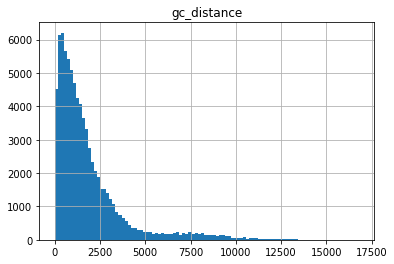

In [17]:
ap_dist.hist(bins = 100)
plt.show()

Zoom in to below 50 km (since flights below that threshold are probably only relevant for regional aircraft):

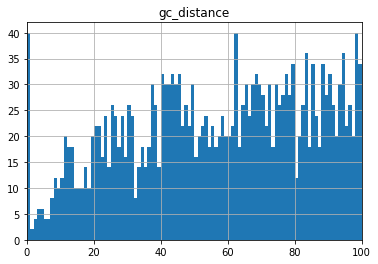

In [18]:
ap_dist[ap_dist['gc_distance'] <= 100].hist(bins = 100)
plt.xlim(0,100)
plt.show()

We observe a peak at 0km - this seems to be invalid data since they represent flights from and to the same airports.

For further analyses, we create a new dataframe for the low-distance AP pairs:

In [19]:
low_ap_gc = ap_dist[ap_dist['gc_distance'] <= 50].sort_values(by='gc_distance')

Number of flights below 50km AP distance:

In [20]:
count = 0
for i in np.arange(len(low_ap_gc)):
    count += oag18[(oag18['arr_ap_code'] == low_ap_gc.iloc[i,0]) & (oag18['dep_ap_code'] == low_ap_gc.iloc[i,1])].loc[:,'frequency_2018'].sum()
    count += oag18[(oag18['arr_ap_code'] == low_ap_gc.iloc[i,1]) & (oag18['dep_ap_code'] == low_ap_gc.iloc[i,0])].loc[:,'frequency_2018'].sum()

In [21]:
count

573986.0

AC that performed these flights:

In [22]:
AC_list = []
for i in np.arange(len(low_ap_gc)-100):
    if (oag18[(oag18['arr_ap_code'] == low_ap_gc.iloc[i,0]) & (oag18['dep_ap_code'] == low_ap_gc.iloc[i,1])]).empty == False:
        AC_list.extend(list(oag18[(oag18['arr_ap_code'] == low_ap_gc.iloc[i,0]) & (oag18['dep_ap_code'] == low_ap_gc.iloc[i,1])].loc[:,'ac_name_oag']))
    if (oag18[(oag18['arr_ap_code'] == low_ap_gc.iloc[i,1]) & (oag18['dep_ap_code'] == low_ap_gc.iloc[i,0])].loc[:,'ac_name_oag']).empty == False:
        AC_list.extend(list(oag18[(oag18['arr_ap_code'] == low_ap_gc.iloc[i,1]) & (oag18['dep_ap_code'] == low_ap_gc.iloc[i,0])].loc[:,'ac_name_oag']))

In [23]:
AC_list = pd.DataFrame({"AC_type_oag": AC_list})

In [24]:
AC_list.loc[:,'AC_type_oag'].unique()

array(['Fokker 100', 'Cessna (Light Aircraft)', 'Airbus A319',
       'Airbus A318/319/320/321',
       'Cessna Light Aircraft(Single Turboprop)',
       'Cessna Light Acft(single Piston Engine)',
       'Boeing (douglas) MD-81', 'Boeing (douglas) MD-82',
       'Boeing 737-500 Passenger', 'ATR42 /ATR72',
       'Canadair Regional Jet 700', 'Beechcraft 1900D Airliner',
       'Pilatus PC-12', 'Boeing 737-800 Passenger',
       'Canadair Regional Jet 200', 'ATR 42-300 /320',
       'DHvilld-Bombardier DHC2 Bvr', 'BN BN-2a /BN-2b Islander',
       'Beechcraft (Lght Acft - Twin Turboprop)',
       'DHvilld-Bombardier DHC6 T/Otter', 'Piper (Light Aircraft)',
       'Beechcraft 1900 Airliner', 'Airbus A320',
       'Boeing 737-900 Passenger', 'DHvilld-Bombardier DHC8 Dsh 8',
       'DHvilld-Bombardier DHC8-100 Dsh 8/8Q', 'Cessna 208B Caravan',
       'Cessna 208b Freighter', 'DHvilld-Bombardier DHC8-300 Dsh 8/8Q',
       'DHvilld-Bombardier DHC3 Tb Otter',
       'Fairchild Sa26 /Sa226 /Sa2

These are mainly regional aircraft, operating between two close regional airports. However, there are also some movements of bigger aircraft which seem to be transfers from and to adjacent airports.

### Merge distance table with OAG table and compute total FKM

In [25]:
oag18 = oag18.merge(ap_dist, left_on=['dep_ap_code','arr_ap_code'], right_on=['ap1','ap2'],how = 'left')
oag18 = oag18.drop(['ap1', 'ap2'], axis=1)

In [26]:
oag18['fkm_2018'] = oag18['gc_distance'] * oag18['frequency_2018']

We delete all entries with a gc_distance = 0.

In [27]:
idx_to_del = oag18[oag18['gc_distance'] == 0].index
oag18 = oag18.drop(index = idx_to_del)

### Remove great circle distance outliers

Apply a multiple pass Z-Score filter

In [28]:
# Take the complete set of routes operated by an A/C type and calculate the z score of the great circle distance values
oag18_z_scores1 = oag18.copy()
oag18_z_scores1['z_score'] = ''
for ac in oag18_z_scores1.ac_code_iata.unique():
    oag18_z_scores1.loc[oag18_z_scores1.ac_code_iata==ac,'z_score'] = abs(stats.zscore(oag18_z_scores1.loc[oag18_z_scores1.ac_code_iata==ac,'gc_distance']))
    
oag18_filtered1 = oag18.loc[(oag18_z_scores1.z_score<5)|oag18_z_scores1.z_score.isna()]
oag18_removed1 = oag18.loc[oag18_z_scores1.z_score>=5]
print('{:,.0f} ({:.2f}% of total) routes have been removed by filtering great circle distance z scores that are greater than 5 in the first pass.'.format(len(oag18_removed1),len(oag18_removed1)/len(oag18)*100))

oag18_filtered1.reset_index(drop=True,inplace=True)

# Second Pass
oag18_z_scores2 = oag18_filtered1.copy()
oag18_z_scores2['z_score'] = ''
for ac in oag18_z_scores2.ac_code_iata.unique():
    oag18_z_scores2.loc[oag18_z_scores2.ac_code_iata==ac,'z_score'] = abs(stats.zscore(oag18_z_scores2.loc[oag18_z_scores2.ac_code_iata==ac,'gc_distance']))
    
oag18_filtered2 = oag18_filtered1.loc[(oag18_z_scores2.z_score<6)|oag18_z_scores2.z_score.isna()]
oag18_removed2 = oag18_filtered1.loc[oag18_z_scores2.z_score>=6]
print('{:,.0f} ({:.2f}% of total) routes have been removed by filtering great circle distance z scores that are greater than 6 in the second pass.'.format(len(oag18_removed2),len(oag18_removed2)/len(oag18)*100))

C:\Users\heldm\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


137 (0.07% of total) routes have been removed by filtering great circle distance z scores that are greater than 5 in the first pass.
33 (0.02% of total) routes have been removed by filtering great circle distance z scores that are greater than 6 in the second pass.


The runtime warning occurs for aircraft types which only have one flight route (standard deviation=0). For such cases, NaN are returned and these are accounted for when filtering the dataset below.

In [29]:
# View the distribution of great circle distances for a few select aircraft before and after filtering
fig,ax = plt.subplots(nrows=3,ncols=9,figsize=(15,10))
select_ac = ['AT7','7M8','DH4','DHT','733','73W','321','318','CNC']
for i,ac in enumerate(select_ac):
    sns.boxplot(y='gc_distance', data=oag18.loc[oag18.ac_code_iata==ac],ax=ax[0,i])
    ax[0,i].set_ylabel(None)
    ax[0,i].set_title(ac,fontsize=15)
    for j,filtered_dataset in enumerate([oag18_filtered1,oag18_filtered2]):
        schedule_ac_slice = filtered_dataset.loc[filtered_dataset.ac_code_iata==ac]
        sns.boxplot(y='gc_distance', data=schedule_ac_slice,ax=ax[j+1,i])
        ax[j+1,i].set_ylim(ax[0,i].get_ylim())
        ax[j+1,i].set_ylabel(None)
ax[0,0].set_ylabel('GC Distance\n(unfiltered)',fontsize=15)
ax[1,0].set_ylabel('GC Distance \n(filter pass 1',fontsize=15)
ax[2,0].set_ylabel('GC Distance \n(filter pass 2)',fontsize=15)
plt.tight_layout()

In [30]:
oag18 = oag18_filtered2.reset_index(drop=True)

In [31]:
del oag18_filtered1, oag18_filtered2

In [32]:
preview(oag18)

,ac_code_iata,ac_name_oag,arr_ap_code,arr_ap_name,dep_ap_code,dep_ap_name,frequency_2018,gc_distance,fkm_2018
0,100,Fokker 100,ADE,Aden,JIB,Djibouti,58.0,248.203212,14395.786303
1,100,Fokker 100,AMS,Amsterdam,BRU,Brussels Airport,88.0,157.553624,13864.718918
2,100,Fokker 100,AMS,Amsterdam,MUC,Munich International Airport,332.0,676.777570,224690.153347
3,100,Fokker 100,AZD,Yazd,BND,Bandar Abbas,91.0,559.459639,50910.827163
4,100,Fokker 100,BND,Bandar Abbas,AZD,Yazd,91.0,559.459639,50910.827163


This dataframe has 182930 observations.


## Add airport country to OAG data

In [33]:
ap = pd.read_csv('../../../../Research/Aviation/Jupyter/datasets/airports.csv', index_col=0, na_values='', keep_default_na=False)
ap = ap.rename(columns =  {'iata_code': 'ap_code_iata',
                          'icao_code': 'ap_code_icao'}
              )
ap.head()

,ap_code_iata,ap_code_icao,country_code,country_name,latitude,longitude,elev_ft,nrunways,longest_runway_ft,name,traffic_region
0,ORD,KORD,US,United States,41.978056,-87.906111,672.0,7.0,13000.0,NaN,North America
1,ATL,KATL,US,United States,33.640833,-84.427222,1026.0,6.0,11890.0,NaN,North America
2,DFW,KDFW,US,United States,32.896389,-97.041111,607.0,8.0,13401.0,NaN,North America
3,LAX,KLAX,US,United States,33.942222,-118.407222,125.0,5.0,12091.0,NaN,North America
4,IAH,KIAH,US,United States,29.983333,-95.340000,97.0,5.0,12001.0,NaN,North America


In [34]:
# Create an airport-country lookup dictionary
ap_cty_lookup = ap.set_index('ap_code_iata').to_dict()['country_code']
dict(list(ap_cty_lookup.items())[0:3]) # preview

{'ATL': 'US', 'DFW': 'US', 'ORD': 'US'}

In [35]:
oag18['arr_ap_cty'] = oag18['arr_ap_code'].replace(ap_cty_lookup)
oag18['dep_ap_cty'] = oag18['dep_ap_code'].replace(ap_cty_lookup)

### Merge ap country table with OAG table

In [36]:
# Resort columns
col_names = ['ac_code_iata', 'ac_name_oag', 'dep_ap_code', 'dep_ap_name', 'dep_ap_cty', 
             'arr_ap_code','arr_ap_name', 'arr_ap_cty', 'gc_distance', 'frequency_2018', 'fkm_2018']
oag18 = oag18[col_names]
oag18.head()

,ac_code_iata,ac_name_oag,dep_ap_code,dep_ap_name,dep_ap_cty,arr_ap_code,arr_ap_name,arr_ap_cty,gc_distance,frequency_2018,fkm_2018
0,100,Fokker 100,JIB,Djibouti,DJ,ADE,Aden,YE,248.203212,58.0,14395.786303
1,100,Fokker 100,BRU,Brussels Airport,BE,AMS,Amsterdam,NL,157.553624,88.0,13864.718918
2,100,Fokker 100,MUC,Munich International Airport,DE,AMS,Amsterdam,NL,676.777570,332.0,224690.153347
3,100,Fokker 100,BND,Bandar Abbas,IR,AZD,Yazd,IR,559.459639,91.0,50910.827163
4,100,Fokker 100,AZD,Yazd,IR,BND,Bandar Abbas,IR,559.459639,91.0,50910.827163


## Merge duplicate aircraft and airports (with slightly different ac/ap_names)

In [37]:
# For the sanity check (that we do not kill or clone any entries) we copy the inital data set.
oag18_copy = oag18.copy()

### Identical aircraft codes, differing aircraft names

We observed that some aircraft have very similar but not identical names.
We set a unique name for these aircraft:

In [38]:
ac_name_test = oag18.groupby(['ac_code_iata', 'ac_name_oag']).count()
ac_name_test = ac_name_test.reset_index()
(ac_name_test['ac_code_iata'].value_counts() > 1).sort_values(ascending = False).head()

CNF     True
YK2     True
DHD    False
DHC    False
77L    False
Name: ac_code_iata, dtype: bool

In [39]:
# Set common names for the same ac_code:
oag18.at[(oag18['ac_code_iata'] == 'YK2'),'ac_name_oag'] = 'Yakovlev Yak-42/142' # different writing
oag18.at[(oag18['ac_code_iata'] == 'CNF'),'ac_name_oag'] = 'Cessna 208B Caravan'# different writing
oag18.at[(oag18['ac_code_iata'] == 'CS1'),'ac_name_oag'] = 'Airbus A220-100' # Bombardier CSeries transformed to A220
oag18.at[(oag18['ac_code_iata'] == 'CS3'),'ac_name_oag'] = 'Airbus A220-300' # Bombardier CSeries transformed to A220

Now that we set common names for the same ac_code, we will see duplicates for identical ap-pairs. We merge them.

In [40]:
to_be_merged = oag18[oag18.duplicated(subset = ['ac_code_iata','dep_ap_code', 'arr_ap_code','dep_ap_name', 'arr_ap_name', 'gc_distance'], keep=False)].sort_index()
grouped = to_be_merged.groupby(['ac_code_iata','dep_ap_code', 'arr_ap_code'])

In [41]:
for ac_group in grouped.groups.keys():
    grouped.get_group(ac_group).index[0]
    idx_first_entry = grouped.get_group(ac_group).index[0]
    idx_other_entries = grouped.get_group(ac_group).index[1:]
    freq_sum = grouped.get_group(ac_group).sum()['frequency_2018']
    fkm_sum = grouped.get_group(ac_group).sum()['fkm_2018']

    # We update the summed up freq and fkm and set it as new value for the 1st entry
    oag18.at[idx_first_entry, 'frequency_2018'] = freq_sum
    oag18.at[idx_first_entry, 'fkm_2018'] = fkm_sum
    
    # We delete all duplicated values except the first one (which is the one with the updated information)
    oag18.drop_duplicates(subset=['ac_code_iata','dep_ap_code', 'arr_ap_code','dep_ap_name', 'arr_ap_name', 'gc_distance'], keep='first',inplace=True) 

In [42]:
# Sanity check.
print(oag18['fkm_2018'].sum() == oag18_copy['fkm_2018'].sum())
print(oag18['frequency_2018'].sum() == oag18_copy['frequency_2018'].sum())
print('We came down from {} rows in the original data set to currently {} rows.'.format(len(oag18_copy), len(oag18)))

False
True
We came down from 182930 rows in the original data set to currently 182850 rows.


### Identical airport codes, differing airport names

Now we check the duplicates for different airport names that have the same ap codes:

In [43]:
to_be_merged2 = oag18[oag18.duplicated(subset = ['dep_ap_code','arr_ap_code', 'ac_code_iata', 'gc_distance'], keep=False)].sort_values(by = ['ac_code_iata', 'dep_ap_code'])
grouped2 = to_be_merged2.groupby(['dep_ap_code','arr_ap_code', 'ac_code_iata', 'gc_distance'])

In [44]:
for ac_group in grouped2.groups.keys():
    grouped2.get_group(ac_group).index[0]
    idx_first_entry = grouped2.get_group(ac_group).index[0]
    idx_other_entries = grouped2.get_group(ac_group).index[1:]
    freq_sum = grouped2.get_group(ac_group).sum()['frequency_2018']
    fkm_sum = grouped2.get_group(ac_group).sum()['fkm_2018']
    
    # We update the summed up freq and fkm and set it as new value for the 1st entry
    oag18.at[idx_first_entry, 'frequency_2018'] = freq_sum
    oag18.at[idx_first_entry, 'fkm_2018'] = fkm_sum
    
    # We delete all duplicated values except the first one (which is the one with the updated information)
    oag18.drop_duplicates(subset=['dep_ap_code','arr_ap_code', 'ac_code_iata', 'gc_distance'], keep='first',inplace=True) 

In [45]:
# Sanity check.
print(oag18['fkm_2018'].sum() == oag18_copy['fkm_2018'].sum())
print(oag18['frequency_2018'].sum() == oag18_copy['frequency_2018'].sum())
print('We came down from {} rows in the original data set to currently {} rows.'.format(len(oag18_copy), len(oag18)))

False
True
We came down from 182930 rows in the original data set to currently 180578 rows.


The first sanity check is false, but only for a rounding error reason:

In [46]:
oag18['fkm_2018'].sum() - oag18_copy['fkm_2018'].sum()

-7.62939453125e-06

## Upload data

Final info on the data set:

In [47]:
oag18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180578 entries, 0 to 182929
Data columns (total 11 columns):
ac_code_iata      180578 non-null object
ac_name_oag       180578 non-null object
dep_ap_code       180578 non-null object
dep_ap_name       180578 non-null object
dep_ap_cty        180578 non-null object
arr_ap_code       180578 non-null object
arr_ap_name       180578 non-null object
arr_ap_cty        180578 non-null object
gc_distance       180578 non-null float64
frequency_2018    180578 non-null float64
fkm_2018          180578 non-null float64
dtypes: float64(3), object(8)
memory usage: 16.5+ MB


In [48]:
for col in oag18.columns[:6]:
    print("Maximum string length in "+col+" column: "+str(oag18[col].apply(len).max()))

Maximum string length in ac_code_iata column: 3
Maximum string length in ac_name_oag column: 39
Maximum string length in dep_ap_code column: 3
Maximum string length in dep_ap_name column: 39
Maximum string length in dep_ap_cty column: 2
Maximum string length in arr_ap_code column: 3


In [49]:
preview(oag18)

,ac_code_iata,ac_name_oag,dep_ap_code,dep_ap_name,dep_ap_cty,arr_ap_code,arr_ap_name,arr_ap_cty,gc_distance,frequency_2018,fkm_2018
0,100,Fokker 100,JIB,Djibouti,DJ,ADE,Aden,YE,248.203212,58.0,14395.786303
1,100,Fokker 100,BRU,Brussels Airport,BE,AMS,Amsterdam,NL,157.553624,88.0,13864.718918
2,100,Fokker 100,MUC,Munich International Airport,DE,AMS,Amsterdam,NL,676.777570,332.0,224690.153347
3,100,Fokker 100,BND,Bandar Abbas,IR,AZD,Yazd,IR,559.459639,91.0,50910.827163
4,100,Fokker 100,AZD,Yazd,IR,BND,Bandar Abbas,IR,559.459639,91.0,50910.827163


This dataframe has 180578 observations.


In [50]:
for col in oag18.columns:
    print('COMMENT ON\nCOLUMN "OAG"."2018_schedule"."{}" IS ;'.format(col))

COMMENT ON
COLUMN "OAG"."2018_schedule"."ac_code_iata" IS ;
COMMENT ON
COLUMN "OAG"."2018_schedule"."ac_name_oag" IS ;
COMMENT ON
COLUMN "OAG"."2018_schedule"."dep_ap_code" IS ;
COMMENT ON
COLUMN "OAG"."2018_schedule"."dep_ap_name" IS ;
COMMENT ON
COLUMN "OAG"."2018_schedule"."dep_ap_cty" IS ;
COMMENT ON
COLUMN "OAG"."2018_schedule"."arr_ap_code" IS ;
COMMENT ON
COLUMN "OAG"."2018_schedule"."arr_ap_name" IS ;
COMMENT ON
COLUMN "OAG"."2018_schedule"."arr_ap_cty" IS ;
COMMENT ON
COLUMN "OAG"."2018_schedule"."gc_distance" IS ;
COMMENT ON
COLUMN "OAG"."2018_schedule"."frequency_2018" IS ;
COMMENT ON
COLUMN "OAG"."2018_schedule"."fkm_2018" IS ;


In [51]:
%pg_sql set role "NDA-OAG-full"

SUCCESS: query did not return any data


<cursor object at 0x0000027D7083A048; closed: 0>

In [52]:
%%pg_sql cur
drop table if exists "OAG"."2018_schedule";

CREATE TABLE "OAG"."2018_schedule" 
("ac_code_iata" varchar(3), 
 "ac_name_oag" varchar(39), 
 "arr_ap_code" varchar(3),
 "arr_ap_name" varchar(39),
 "arr_ap_cty" varchar(3),
 "dep_ap_code" varchar(3),
 "dep_ap_name" varchar(39),
 "dep_ap_cty" varchar(3),
 "gc_distance" float,
 "frequency_2018" float,
 "fkm_2018" float
);

COMMENT ON
COLUMN "OAG"."2018_schedule"."ac_code_iata" IS 'IATA aircraft code';
COMMENT ON
COLUMN "OAG"."2018_schedule"."ac_name_oag" IS 'OAG aircraft name';
COMMENT ON
COLUMN "OAG"."2018_schedule"."arr_ap_code" IS 'IATA aiport code';
COMMENT ON
COLUMN "OAG"."2018_schedule"."arr_ap_name" IS 'IATA aiport name';
COMMENT ON
COLUMN "OAG"."2018_schedule"."arr_ap_cty" IS  'IATA airport country';
COMMENT ON
COLUMN "OAG"."2018_schedule"."dep_ap_code" IS 'IATA aiport code';
COMMENT ON
COLUMN "OAG"."2018_schedule"."dep_ap_name" IS 'IATA aiport name';
COMMENT ON
COLUMN "OAG"."2018_schedule"."dep_ap_cty" IS 'IATA airport country';
COMMENT ON
COLUMN "OAG"."2018_schedule"."gc_distance" IS 'great-circle distance for this segment';
COMMENT ON
COLUMN "OAG"."2018_schedule"."frequency_2018" IS 'number of flights for this segment in 2018';
COMMENT ON
COLUMN "OAG"."2018_schedule"."fkm_2018" IS 'flight kilometers for this segment (gc_distance * frequency)';

COMMIT;

SUCCESS: query did not return any data
 cursor object as 'cur'


In [53]:
%pg_copy oag18 OAG.2018_schedule

  waring: green-mode temporarily deactivated (interrupt won't abort the import)  green mode reactivated

In [54]:
%pg_disconnect